In [1]:
import numpy as np
import pandas as pd

# Predicting S&P500 Dividend Yields using Linear Regression

#### Special thanks to Dan Hirlea for his support and advice throughout this project!

#### In this short notebook we will predict SPX500 dividends one month into the future using previous yields as features. The notebook consists of the following steps:
#### 1. Retrieving the data
#### 2. Data pre-processing
#### 3. Data modelling
#### 4. Predicting
#### 5. Assessing our model

### ^These are the key steps for almost all Machine Learning modelling, including the creation of ChatGPT!

## 1. Retrieving the Data

The following cells reads in an excel file containing SPX dividend yields (monthly):

In [2]:
data = pd.read_excel('spx div yields.xlsx', usecols = ['date', 'div yield'], sheet_name='monthly')
data = data.set_index('date')
data.index = pd.to_datetime(data.index, format='%d/%m/%Y')
data.head()

,div yield
date,
1990-01-31,3.51
1990-02-28,3.56
1990-03-30,3.49
1990-04-30,3.61
1990-05-31,3.29


Plotting our data to see what it looks like:

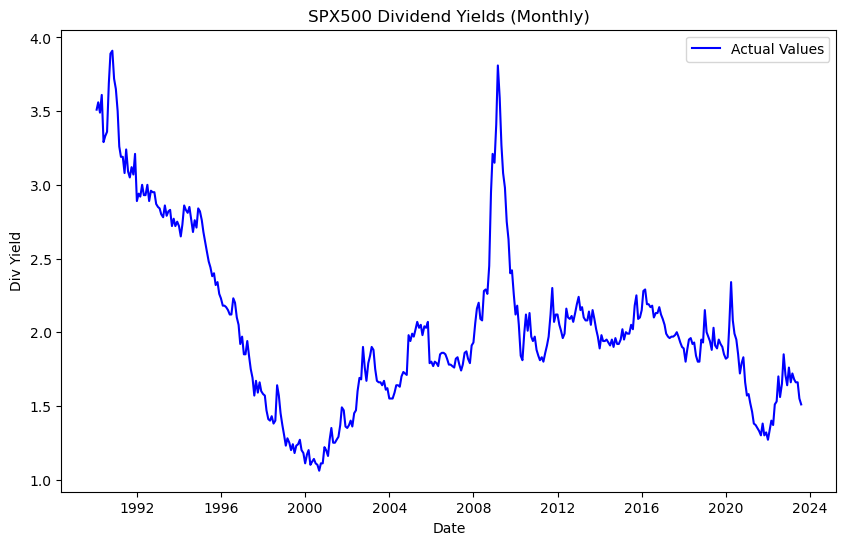

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['div yield'], label='Actual Values', color='blue')

plt.xlabel('Date')
plt.ylabel('Div Yield')
plt.title('SPX500 Dividend Yields (Monthly)')
plt.legend()

plt.show()

## 2. Data pre-processing

### Statistical Test for Stationarity (mean and standard deviation constant over the whole period).

When dealing with time series data (almost always the case in asset management) it is usually best for your data to be stationary (mean and std are constant over time) - this makes sure your model captures the key underlying relationships between our features and targets instead of seasonal trends/other noise.

In [4]:
from statsmodels.tsa.stattools import adfuller

def stat_test(data):
    result = adfuller(data)
    
    print(f'p-value: {result[1]}')

    if result[1] <= 0.05:
        print("The data is likely stationary.")
    else:
        print("The data is likely non-stationary.")
        

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dividend yields are not stationary

In [5]:
stat_test(data['div yield'])

p-value: 0.10386144179279505
The data is likely non-stationary.


### Subtract the current dividend yield from the previous one to make data stationary

In [6]:
data['diff_yield'] = data['div yield'].diff()
data

,div yield,diff_yield
date,,
1990-01-31,3.51,NaN
1990-02-28,3.56,0.05
1990-03-30,3.49,-0.07
1990-04-30,3.61,0.12
1990-05-31,3.29,-0.32
...,...,...
2023-03-31,1.68,-0.04
2023-04-28,1.66,-0.02
2023-05-31,1.66,0.00


### The consecutive differences in dividend yields ARE stationary

In [7]:
stat_test(data['diff_yield'][1:])

p-value: 2.7840298199457535e-13
The data is likely stationary.


### Creating Features - Performing Lags

Here we are adding the previous 100 month DIFFERENCES in dividend yields to predict the current month's dividend yield. These previous 100 differences in dividend yields are called 'features' - our model will try to learn relationships between these and the current month's dividend yield.

In [8]:
lag_window = 100
rows = []
#take the previous 101 dividend yields and find consecutive difference between each
for i in range(lag_window, data.shape[0]):
    lagged_yield_differences = data.iloc[i - lag_window:i]['diff_yield'].values
    rows.append(lagged_yield_differences)

X_df = pd.DataFrame(rows, columns=[f'{i} months back' for i in range(lag_window, 0, -1)])
X_df = X_df.set_index(data[lag_window:].index)


X_df['div yield'] = data.iloc[lag_window:]['div yield'].values
X_df.dropna(inplace=True)

Taking a look at our data now:

In [9]:
X_df

,100 months back,99 months back,98 months back,97 months back,96 months back,95 months back,94 months back,93 months back,92 months back,91 months back,...,9 months back,8 months back,7 months back,6 months back,5 months back,4 months back,3 months back,2 months back,1 months back,div yield
date,,,,,,,,,,,,,,,,,,,,,
1998-06-30,0.05,-0.07,0.12,-0.32,0.04,0.03,0.33,0.20,0.02,-0.19,...,-0.08,0.07,-0.06,-0.02,-0.01,-0.10,-0.06,-0.01,0.03,1.38
1998-07-31,-0.07,0.12,-0.32,0.04,0.03,0.33,0.20,0.02,-0.19,-0.07,...,0.07,-0.06,-0.02,-0.01,-0.10,-0.06,-0.01,0.03,-0.05,1.40
1998-08-31,0.12,-0.32,0.04,0.03,0.33,0.20,0.02,-0.19,-0.07,-0.15,...,-0.06,-0.02,-0.01,-0.10,-0.06,-0.01,0.03,-0.05,0.02,1.64
1998-09-30,-0.32,0.04,0.03,0.33,0.20,0.02,-0.19,-0.07,-0.15,-0.24,...,-0.02,-0.01,-0.10,-0.06,-0.01,0.03,-0.05,0.02,0.24,1.57
1998-10-30,0.04,0.03,0.33,0.20,0.02,-0.19,-0.07,-0.15,-0.24,-0.07,...,-0.01,-0.10,-0.06,-0.01,0.03,-0.05,0.02,0.24,-0.07,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.00,0.03,0.07,-0.07,0.05,-0.01,0.00,0.06,-0.03,0.16,...,0.17,-0.14,0.09,0.20,-0.14,-0.07,0.12,-0.10,0.06,1.68
2023-04-28,0.03,0.07,-0.07,0.05,-0.01,0.00,0.06,-0.03,0.16,0.07,...,-0.14,0.09,0.20,-0.14,-0.07,0.12,-0.10,0.06,-0.04,1.66
2023-05-31,0.07,-0.07,0.05,-0.01,0.00,0.06,-0.03,0.16,0.07,-0.16,...,0.09,0.20,-0.14,-0.07,0.12,-0.10,0.06,-0.04,-0.02,1.66


### Train/Test Split

Here we split our dataset into training and testing sets. The training dataset is what we feed into the model so that it can learn the relationships between 100 month lags and dividend yields, and the test dataset is what we are going to test our model on. Our test dataset starts from 2020, so we will be predicting the dividend yields from 2020 onwards and then compare them to the actual results to see how strong our model is.

In [10]:
split_date = '2020-01-01'

train = X_df.loc[X_df.index  < split_date]
test = X_df.loc[X_df.index >= split_date]

In [11]:
X_train = train.drop(['div yield'], axis=1)
X_test = test.drop(['div yield'], axis=1)

y_train = train['div yield']
y_test = test['div yield']

## 3. Modelling

Feeding our data into a linear regression model.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## 4. Predicting

Making predictions on our test dataset.

In [13]:
preds = model.predict(X_test)

## 5. Assessment

#### Let's see how our model performed!

#### Mean squared error

In [14]:
mse = mean_squared_error(preds, y_test)
mse

0.0451478582316807

#### Plotting

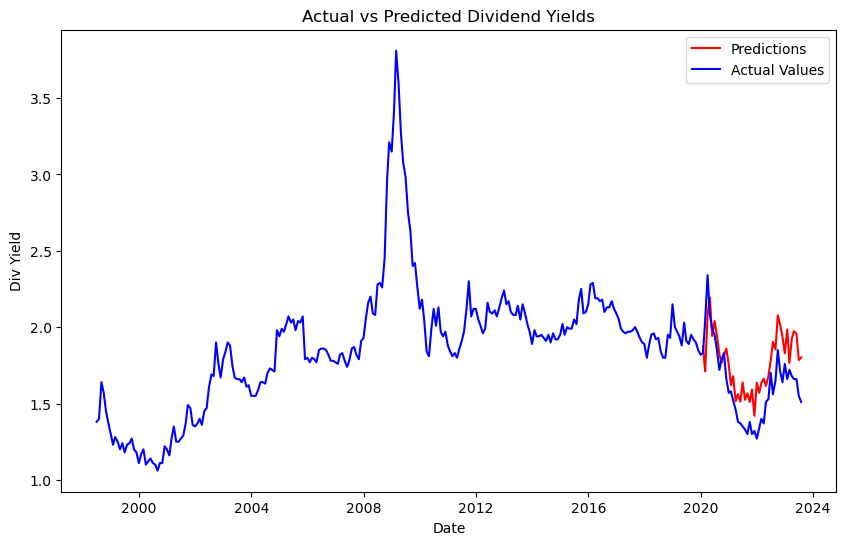

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, preds, label='Predictions', color='red')
plt.plot(X_df.index, X_df['div yield'], label='Actual Values', color='blue')

plt.xlabel('Date')
plt.ylabel('Div Yield')
plt.title('Actual vs Predicted Dividend Yields')
plt.legend()

plt.show()

## Final Notes

#### How practical is this model?
* The use of this particular model is limited - we are only predicting yields one month into the future
* Linear regression only captures linear relationships

#### How could one improve this model?
* Use other models more fit for capturing relationships in the data (this is where domain expertise becomes significant).
* Examples are Multi-layer perceptrons, Long short term memory models, Random Forest Regressor...

#### Why Dividend Yields?
* Generally more stable than stock/bond prices, which are very complex to model due to the number of influencing factors.

#### Key takeaways
* Machine Learning/Deep Learning can capture patterns in our data much more easily than humans!
* The challenge lies in engineering your data (step 2) and choosing a model (step 3) such that your model can learn the necessary relationships between features and targets. It is important to understand the underlying themes behind your data (e.g., stationarity, frequency, driving factors).